# Image Captioning System
## [Based on Flickr 8k Data](https://www.kaggle.com/shadabhussain/flickr8k)

Streamlit Front End + Tensorflow Backend

- [ ] Model Training
    - [x] Data Collection
    - [x] Understanding Data
    - [x] Data Cleaning
    - [x] Loading the training Set
    - [x] Data Preprocessing- Images
    - [x] Data Preprocessing- Captions
    - [x] Data Preperation using Generator Function
    - [x] Word Embedding
    - [x] Model Architecture
    - [x] Inference
    - [x] Evaluation
- [ ] Backend
- [x] Frontend
- [ ] Try Advance Models like Transformers/GPT-3 (Optional)

In [1]:
!mkdir ~/.kaggle

In [2]:
!cp /content/kaggle.json ~/.kaggle/kaggle.json

In [3]:
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d shadabhussain/flickr8k

100% 2.13G/2.13G [01:10<00:00, 30.6MB/s]
100% 2.13G/2.13G [01:10<00:00, 32.5MB/s]


### Loading Data

In [5]:
!unzip flickr8k.zip

Streaming output truncated to the last 5000 lines.
  inflating: flickr_data/Flickr_Data/Images/2845845721_d0bc113ff7.jpg  
  inflating: flickr_data/Flickr_Data/Images/2846037553_1a1de50709.jpg  
  inflating: flickr_data/Flickr_Data/Images/2846785268_904c5fcf9f.jpg  
  inflating: flickr_data/Flickr_Data/Images/2846843520_b0e6211478.jpg  
  inflating: flickr_data/Flickr_Data/Images/2847514745_9a35493023.jpg  
  inflating: flickr_data/Flickr_Data/Images/2847615962_c330bded6e.jpg  
  inflating: flickr_data/Flickr_Data/Images/2847859796_4d9cb0d31f.jpg  
  inflating: flickr_data/Flickr_Data/Images/2848266893_9693c66275.jpg  
  inflating: flickr_data/Flickr_Data/Images/2848571082_26454cb981.jpg  
  inflating: flickr_data/Flickr_Data/Images/2848895544_6d06210e9d.jpg  
  inflating: flickr_data/Flickr_Data/Images/2848977044_446a31d86e.jpg  
  inflating: flickr_data/Flickr_Data/Images/2849194983_2968c72832.jpg  
  inflating: flickr_data/Flickr_Data/Images/2850719435_221f15e951.jpg  
  inflating: 

In [8]:
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [9]:
captions = readTextFile('Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt')

In [10]:
captions = captions.split('\n')[:-1]

descriptions = dict()

for caption in captions:
    image_name = caption.split('\t')[0].split('.jpg#')[0]
    image_desc = caption.split('\t')[1]
    
    if descriptions.get(image_name) is None:
        descriptions[image_name] = []
        
    descriptions[image_name].append(image_desc)


In [11]:
descriptions['1002674143_1b742ab4b8']  # Sample

['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
 'A little girl is sitting in front of a large painted rainbow .',
 'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
 'There is a girl with pigtails sitting in front of a rainbow painting .',
 'Young girl with pigtails painting outside in the grass .']

In [12]:
import cv2
import matplotlib.pyplot as plt

def show_image(name):
    img = cv2.imread(f'Flickr_Data/Flickr_Data/Images/{name}.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')

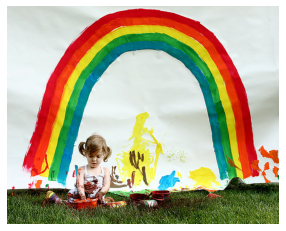

In [13]:
show_image('1002674143_1b742ab4b8')  # Sample

### Data Cleaning

- Do not remove Stop Words (the, is , a , an etc) because then the output will not have these and the output will loose sense of language.
- Do not perform Stemming (Running --> Run etc) because then the output will not have these and the output will loose sense of language.
- Convert to Lower Case.
- Remove Numbers and Punctuations

In [14]:
import re

def clean_text(sentence):
    
    sentence = sentence.lower()
    sentence = re.sub('[^a-z]+', ' ', sentence)
    sentence = sentence.split()
    
    sentence = ' '.join(sentence)
    
    return sentence

In [15]:
clean_text('Cats are not allowed here ok? 1')  # Sample

'cats are not allowed here ok'

In [16]:
for key, descs in descriptions.items():
    for i in range(len(descs)):
        descs[i] = clean_text(descs[i])

In [17]:
descriptions['1002674143_1b742ab4b8']  # Sample

['a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl',
 'a little girl is sitting in front of a large painted rainbow',
 'a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it',
 'there is a girl with pigtails sitting in front of a rainbow painting',
 'young girl with pigtails painting outside in the grass']

In [18]:
with open('descriptions.txt', 'w') as f:
    f.write(str(descriptions))

## Creating Vocabulary

In [19]:
vocab = set()

for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]  # Unique Words

In [20]:
print('Vocab Size:', len(vocab))

Vocab Size: 8441


In [21]:
total_words = []

for key in descriptions.keys():
    [total_words.append(word) for senten in descriptions[key] for word in senten.split()]

In [22]:
print('Total Words:', len(total_words))

Total Words: 437466


In [23]:
total_words[:10]  # Sample

['a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a']

#### Filter Words from the Vocab according to certain threshold frequency

In [24]:
import collections

counter = collections.Counter(total_words)
freq_cnts = dict(counter)

print(len(freq_cnts))

8441


In [25]:
sorted_freq_cnts = sorted(freq_cnts.items(), reverse=True, key=lambda x:x[1])

threshold = 10
sorted_freq_cnts = [x for x in sorted_freq_cnts if x[1]>threshold]

total_words = [x[0] for x in sorted_freq_cnts]

In [26]:
sorted_freq_cnts[:10]

[('a', 62995),
 ('in', 18987),
 ('the', 18420),
 ('on', 10746),
 ('is', 9345),
 ('and', 8863),
 ('dog', 8138),
 ('with', 7765),
 ('man', 7275),
 ('of', 6723)]

In [27]:
print('Total Words:', len(total_words))

Total Words: 1850


### Train Test Split

In [28]:
training_data = readTextFile('Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt')
test_data = readTextFile('Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt')

In [29]:
training_data = [row.split(".")[0] for row in training_data.split("\n")[:-1]]
test_data = [row.split(".")[0] for row in test_data.split("\n")[:-1]]

#### Adding start \<s> and end \<e> token

In [30]:
training_description = {}

for img_id in training_data:
    training_description[img_id] = []
    for cap in descriptions[img_id]:
        cap_appended = '<s> ' + cap + ' <e>'
        training_description[img_id].append(cap_appended)

In [31]:
training_description['1000268201_693b08cb0e'] # Sample

['<s> a child in a pink dress is climbing up a set of stairs in an entry way <e>',
 '<s> a girl going into a wooden building <e>',
 '<s> a little girl climbing into a wooden playhouse <e>',
 '<s> a little girl climbing the stairs to her playhouse <e>',
 '<s> a little girl in a pink dress going into a wooden cabin <e>']

In [32]:
test_description = {}

for img_id in test_data:
    test_description[img_id] = []
    for cap in descriptions[img_id]:
        cap_appended = '<s> ' + cap + ' <e>'
        test_description[img_id].append(cap_appended)

## Image Processing

### Transfer Learning

In [33]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Input, Dropout, Embedding, LSTM, add
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import pickle
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

102973440/102967424 [==============================] - 3s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
________________________

In [34]:
model_front = Model(model.input,model.layers[-2].output)

In [35]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Normalisation
    img = preprocess_input(img)
    return img

In [36]:
def encode_img(img):
    img = preprocess_img(img)
    feature_vector = model_front.predict(img)
    
    feature_vector = feature_vector.reshape((-1, ))
    
    return feature_vector

In [37]:
train_encoded_images = {}

for ix,img_id in enumerate(training_data):
    img_path = 'Flickr_Data/Flickr_Data/Images/'+img_id+".jpg"
    train_encoded_images[img_id] = encode_img(img_path)
    
    if ix%100==0:
        print(f"Encoding in Progress Time step {ix}")

Encoding in Progress Time step 0
Encoding in Progress Time step 100
Encoding in Progress Time step 200
Encoding in Progress Time step 300
Encoding in Progress Time step 400
Encoding in Progress Time step 500
Encoding in Progress Time step 600
Encoding in Progress Time step 700
Encoding in Progress Time step 800
Encoding in Progress Time step 900
Encoding in Progress Time step 1000
Encoding in Progress Time step 1100
Encoding in Progress Time step 1200
Encoding in Progress Time step 1300
Encoding in Progress Time step 1400
Encoding in Progress Time step 1500
Encoding in Progress Time step 1600
Encoding in Progress Time step 1700
Encoding in Progress Time step 1800
Encoding in Progress Time step 1900
Encoding in Progress Time step 2000
Encoding in Progress Time step 2100
Encoding in Progress Time step 2200
Encoding in Progress Time step 2300
Encoding in Progress Time step 2400
Encoding in Progress Time step 2500
Encoding in Progress Time step 2600
Encoding in Progress Time step 2700
Enco

In [38]:
with open("encoded_train_features.pkl","wb") as f:
    pickle.dump(train_encoded_images,f)

In [39]:
test_encoded_images = {}

for ix,img_id in enumerate(test_data):
    img_path = 'Flickr_Data/Flickr_Data/Images/'+img_id+".jpg"
    test_encoded_images[img_id] = encode_img(img_path)
    
    if ix%100==0:
        print(f"Encoding in Progress Time step {ix}")

Encoding in Progress Time step 0
Encoding in Progress Time step 100
Encoding in Progress Time step 200
Encoding in Progress Time step 300
Encoding in Progress Time step 400
Encoding in Progress Time step 500
Encoding in Progress Time step 600
Encoding in Progress Time step 700
Encoding in Progress Time step 800
Encoding in Progress Time step 900


In [40]:

with open("encoded_test_features.pkl","wb") as f:
    pickle.dump(test_encoded_images,f)

## Captions Preprocessing

In [41]:
word_to_idx = {}
idx_to_word = {}

for i, word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word  # Index 0 left to be used for padding for making all sentences equal

In [42]:
word_to_idx['dog']

7

In [43]:
idx_to_word[7]

'dog'

#### Adding \<s> and \<e> tocken

In [44]:
idx_to_word[1851] = '<s>'
word_to_idx['<s>'] = 1851

idx_to_word[1852] = '<e>'
word_to_idx['<e>'] = 1852

In [45]:
len(idx_to_word)

1852

In [46]:
vocab_size = len(word_to_idx) + 1

In [47]:
max_len = 0 
for key in training_description.keys():
    for cap in training_description[key]:
        max_len = max(max_len,len(cap.split()))
        
print(max_len)

38


## Data Generator

In [49]:
def data_generator(train_description, train_encoded_images, word_to_idx, max_length, batch_size):
    X1, X2, y = [], [], []
    n = 0
    
    while True:
        for key, desc_list in train_description.items():
            n += 1
            photo = train_encoded_images[key]
            for desc in desc_list:
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1, len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    xi = pad_sequences([xi], maxlen=max_length, value=0, padding='post')[0]
                    yi = to_categorical([yi], num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield ([np.array(X1), np.array(X2)], np.array(y))
                    X1, X2, y = [], [], []
                    n = 0

### Word Embeding (GloVe)

In [50]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-07-22 08:44:59--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-07-22 08:44:59--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-07-22 08:45:00--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [51]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [52]:
embedding_index = {}

with open('glove.6B.50d.txt') as f:
    for line in f:
        values = line.split()
        
        word = values[0]
        word_embedding = np.array(values[1:], dtype='float')
        
        embedding_index[word] = word_embedding

In [53]:
embedding_index['apple']  # sample

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [54]:
def get_embedding_matrix():
    emb_dims = 50
    
    matrix = np.zeros((vocab_size, emb_dims))
    for word, idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
            
    return matrix

In [55]:
embedding_matrix = get_embedding_matrix()

embedding_matrix.shape

(1853, 50)

In [56]:
embedding_matrix[1851]  # Embedding for <s>

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Model Architechture

In [57]:
input1 = Input(shape=(2048,))  # From Resnet
fe1 = Dropout(0.5)(input1)
fe2 = Dense(256)(fe1)

input2 = Input(shape=(max_len, ))  # Captions
se1 = Embedding(input_dim=vocab_size, output_dim=50, mask_zero=True)(input2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[input1, input2], outputs=outputs)

In [58]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 50)       92650       input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

## Model Training

In [59]:
model.layers[2].set_weights([embedding_matrix])  # Giving Pre-trained Embedding Matrix Weights
model.layers[2].trainable = False

In [60]:
model.layers[2]

In [61]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [62]:
epochs = 20
batch_size = 3
steps = len(training_description)//batch_size

In [63]:
def train():
    
    for i in range(epochs):
        generator = data_generator(training_description,train_encoded_images,word_to_idx,max_len,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('model_'+str(i)+'.h5')

In [64]:
train()

Instructions for updating:
Please use Model.fit, which supports generators.
2000/2000 [==============================] - 51s 26ms/step - loss: 3.7934


In [ ]:
train()

In [67]:
model = load_model('model_19.h5')

## Model Predictions

In [70]:
def predict_caption(photo):
    
    in_text = '<s>'
    
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')
        
        y_pred = model.predict([photo, sequence])
        
        y_pred = y_pred.argmax()  # Greedy Sampling
        word = idx_to_word[y_pred]
        
        in_text += ' ' + word
        
        if word == '<e>':
            break
    final_captions = in_text.split()[1:-1]
    return ' '.join(final_captions)

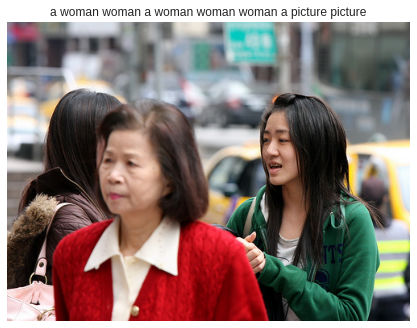

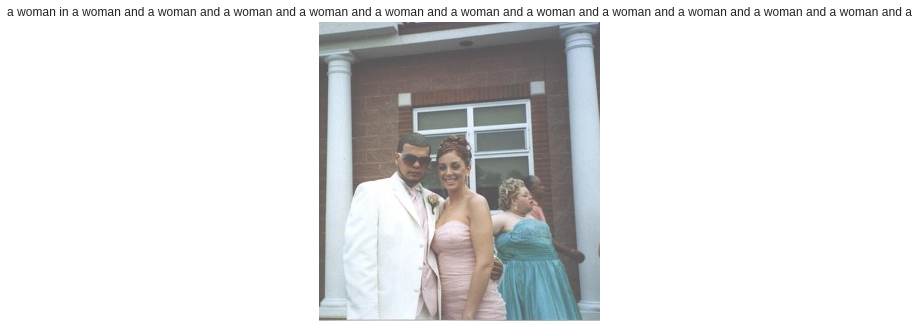

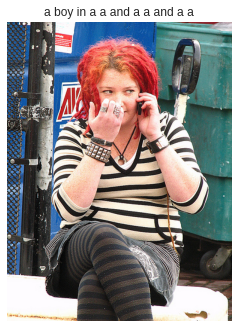

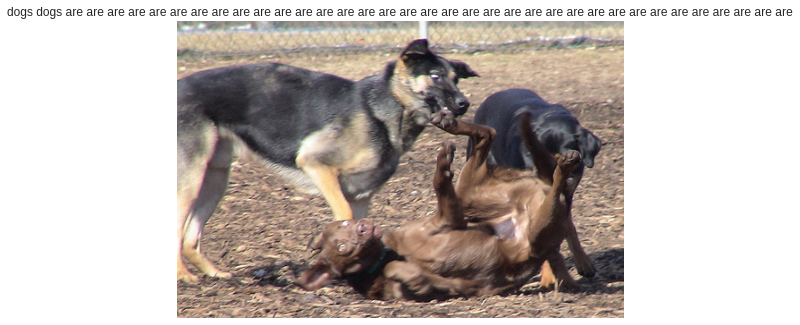

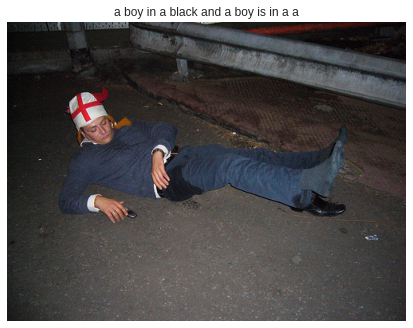

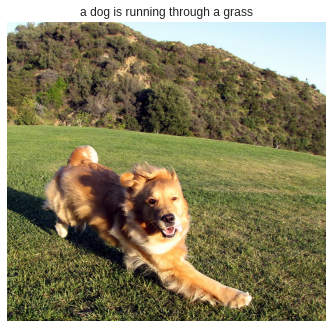

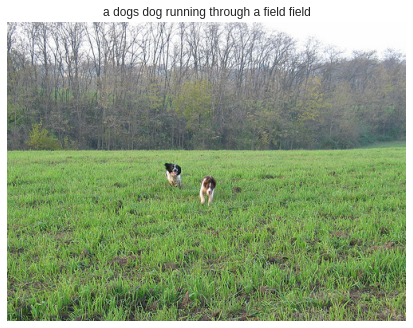

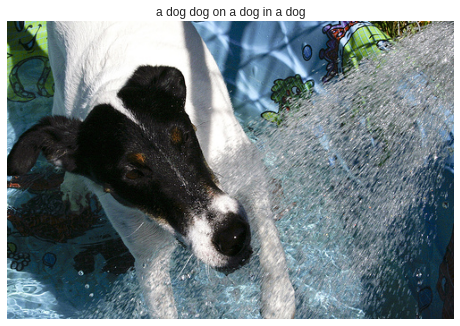

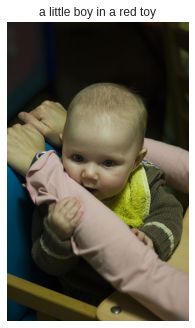

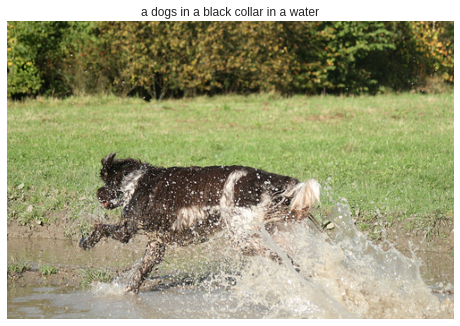

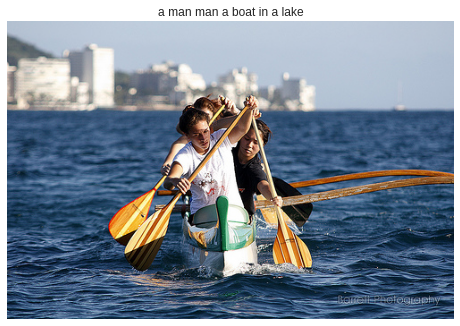

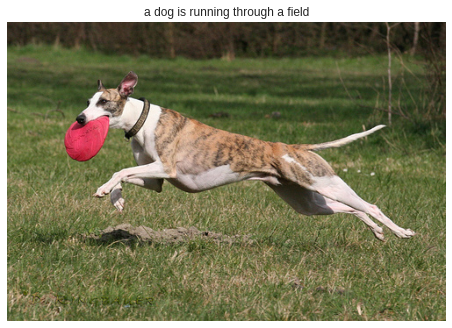

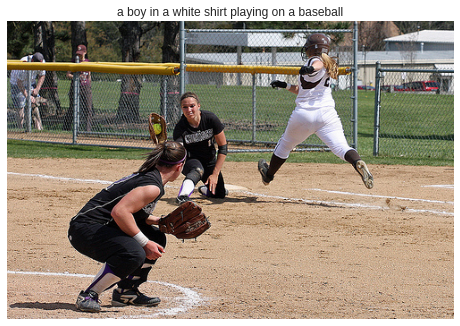

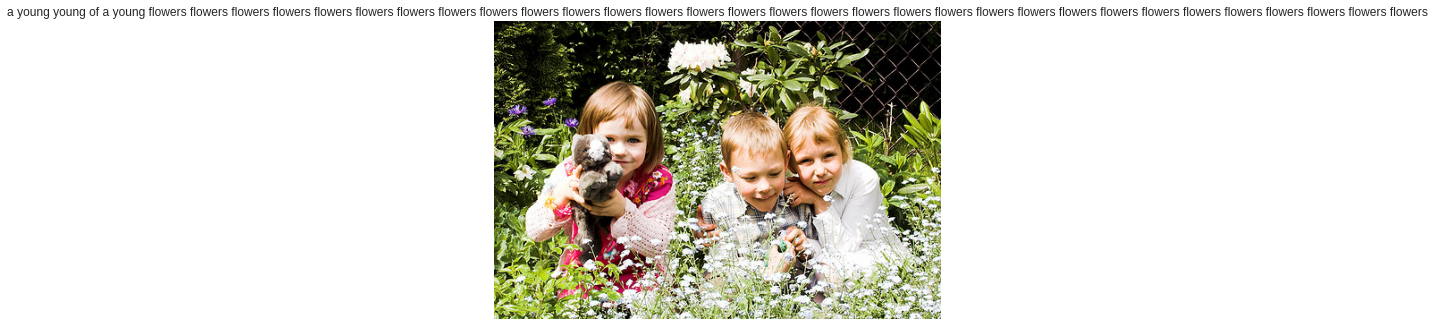

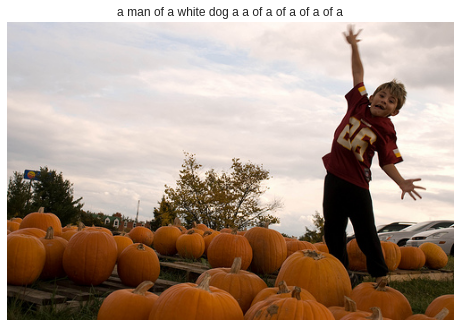

In [71]:
# Pick Some Random Images and See Results
plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(0,6000)
    all_img_names = list(train_encoded_images.keys())
    img_name = all_img_names[idx]
    photo_2048 = train_encoded_images[img_name].reshape((1,2048))
    
    i = plt.imread("Flickr_Data/Flickr_Data/Images/"+img_name+".jpg")
    
    caption = predict_caption(photo_2048)
    #print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()